In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

In [3]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [4]:
# uncertainty for both MLL and Scikit are now sqrt(counts), but implemented differently (std dev versus rand err method in scikit)
# nuc and act trainsets use flat 5% unc/rand err
# 6.7% of the train set is reserved as test set (randomly in each case, but also implemented differently)

### MLL Results

In [5]:
job_act = 'Job0_unc0.05'
job = job_act#'Job1_unc0.0'

# nuc_conc
n29mll = pd.read_csv(mll_nuc + 'train/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# acts
a32mll = pd.read_csv(mll_gam + 'act32/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#a9mll = pd.read_csv(mll_gam + 'act9/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
a4mll = pd.read_csv(mll_gam + 'act4/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# n113
d1mll113 = pd.read_csv(mll_gam + 'd1_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll113 = pd.read_csv(mll_gam + 'd2_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d3mll113 = pd.read_csv(mll_gam + 'd3_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d4mll113 = pd.read_csv(mll_gam + 'd4_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d5mll113 = pd.read_csv(mll_gam + 'd5_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d6mll113 = pd.read_csv(mll_gam + 'd6_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#mll113 = [n29mll, a32mll, a9mll, d1mll113, d2mll113, d3mll113, d6mll113, d5mll113, d4mll113]
mll113 = [n29mll, a32mll, a32mll, d1mll113, d2mll113]

# n31
d1mll31 = pd.read_csv(mll_gam + 'd1_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll31 = pd.read_csv(mll_gam + 'd2_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d3mll31 = pd.read_csv(mll_gam + 'd3_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d4mll31 = pd.read_csv(mll_gam + 'd4_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d5mll31 = pd.read_csv(mll_gam + 'd5_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d6mll31 = pd.read_csv(mll_gam + 'd6_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll31 = [n29mll, a32mll, a4mll, d1mll31, d2mll31, d3mll31, d6mll31, d5mll31, d4mll31]

# auto
#d1mll31 = pd.read_csv(mll_gam + 'd1_auto/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d2mll31 = pd.read_csv(mll_gam + 'd2_auto/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d3mll31 = pd.read_csv(mll_gam + 'd3_auto/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d4mll31 = pd.read_csv(mll_gam + 'd4_auto/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d5mll31 = pd.read_csv(mll_gam + 'd5_auto/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d6mll31 = pd.read_csv(mll_gam + 'd6_auto/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
##mll_auto = [n29mll, a32mll, a9mll, d1mll_auto, d2mll_auto, d3mll_auto, d6mll_auto, d5mll_auto, d4mll_auto]
#mll_auto = [n29mll, a32mll, a32mll, d1mll_auto, d2mll_auto, d3mll_auto, d6mll_auto, d5mll_auto, d4mll_auto]

In [6]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_mimic_mll.csv'
# for dataframes
algcol = ['knn31', 'dtree31', 'mll31', 'knn113', 'dtree113', 'mll113', 'knn_auto', 'dtree_auto', 'mll_auto']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
tfrac = '_tset1.0_'

## Pull all results together into dataframe
### Scikit results are grabbed "live" for results dataframes

23 May 2021 results plotted have the sqrt(counts) errors implemented for scikit + mimic mll updates, but counting error mll results are not yet in, so all MLL results show the flat 5% unc results instead

In [7]:
results = {}
for i, p in enumerate(pred):
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=dets, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for j, d in enumerate(dets):
        ######################
        ### Scikit Results ###
        ######################
        learn_path = learn_gam
        knncsv = p + '_knn' + tfrac + d + csv_end
        dtrcsv = p + '_dtree' + tfrac + d + csv_end
        if 'nuc' in d or 'act' in d:
            # scikit for 113 and 31 lists will both have knn nuc29 & act32 as their starting points
            # then act4, act9 get applied to n31, n113 respectively 
            if d == 'act4/9':
                knncsv = p + '_knn' + tfrac + 'act4' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act4' + csv_end
                knn31 = pd.read_csv(learn_path + 'act4/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = pd.read_csv(learn_path + 'act4/' + dtrcsv).drop(columns='Unnamed: 0')
                knncsv = p + '_knn' + tfrac + 'act9' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act9' + csv_end
                ##### applying act9 to auto, although this isn't accurate #####
                knn_auto = knn113 = pd.read_csv(learn_path + 'act9/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr113 = pd.read_csv(learn_path + 'act9/' + dtrcsv).drop(columns='Unnamed: 0')
            else:
                if 'nuc' in d:
                    learn_path = learn_nuc
                knn_auto = knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            knn_auto = pd.read_csv(learn_path + 'auto/' + knncsv).drop(columns='Unnamed: 0')
            dtr_auto = pd.read_csv(learn_path + 'auto/' + dtrcsv).drop(columns='Unnamed: 0')
            knn31 = pd.read_csv(learn_path + 'n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + 'n31/' + dtrcsv).drop(columns='Unnamed: 0')
            knn113 = pd.read_csv(learn_path + 'n113/' + knncsv).drop(columns='Unnamed: 0')
            dtr113 = pd.read_csv(learn_path + 'n113/' + dtrcsv).drop(columns='Unnamed: 0')
        ###################
        ### Error Calcs ###
        ###################
        if p == 'reactor':
            llmetric = '_Score'
            sign = 1
            dfmetric = 'Accuracy'
            dfstd = 'Acc Std'
        else:
            llmetric = '_Error'
            sign = -1
            dfmetric = 'Neg MAE'
            dfstd = 'MAE Std'
        ### MLL ###
        #df.loc[d, ('mll_auto', dfmetric)] = sign * mll_auto[j][predmll[i] + llmetric].mean()
        #df.loc[d, ('mll_auto', dfstd)] = mll_auto[j][predmll[i] + llmetric].std()
        if j <= 4:
            df.loc[d, ('mll113', dfmetric)] = sign * mll113[j][predmll[i] + llmetric].mean()
            df.loc[d, ('mll113', dfstd)] = mll113[j][predmll[i] + llmetric].std()
        df.loc[d, ('mll31', dfmetric)] = sign * mll31[j][predmll[i] + llmetric].mean()
        df.loc[d, ('mll31', dfstd)] = mll31[j][predmll[i] + llmetric].std()
        ### Scikit ###
        errname = 'AbsError'
        df.loc[d, ('knn_auto', dfmetric)] = sign * knn_auto[errname].mean()
        df.loc[d, ('knn_auto', dfstd)] = knn_auto[errname].std()
        df.loc[d, ('dtree_auto', dfmetric)] = sign * dtr_auto[errname].mean()
        df.loc[d, ('dtree_auto', dfstd)] = dtr_auto[errname].std()
        df.loc[d, ('knn113', dfmetric)] = sign * knn113[errname].mean()
        df.loc[d, ('knn113', dfstd)] = knn113[errname].std()
        df.loc[d, ('dtree113', dfmetric)] = sign * dtr113[errname].mean()
        df.loc[d, ('dtree113', dfstd)] = dtr113[errname].std()    
        df.loc[d, ('knn31', dfmetric)] = sign * knn31[errname].mean()
        df.loc[d, ('knn31', dfstd)] = knn31[errname].std()
        df.loc[d, ('dtree31', dfmetric)] = sign * dtr31[errname].mean()
        df.loc[d, ('dtree31', dfstd)] = dtr31[errname].std()
    results[p] = df

In [8]:
results['cooling']

Algorithm    knn31           dtree31             mll31            knn113  \
Metric     Neg MAE  MAE Std  Neg MAE  MAE Std  Neg MAE  MAE Std  Neg MAE   
nuc29     -262.603  394.255 -47.5787  64.2275 -37.2127  49.8153 -262.603   
act32     -60.1821  56.3929 -50.9297  65.1834   -43.51  48.9563 -60.1821   
act4/9    -132.768  141.414 -109.766  115.936   -35.34  53.2346 -75.1403   
d1_hpge   -81.2975  103.623 -73.3729  103.928 -64.5305  103.664 -84.1181   
d2_hpge   -91.9809  114.115 -84.9787  123.197 -78.8378  123.413 -97.4906   
d3_czt    -104.531  120.083 -110.935  145.628  -95.837  140.848 -102.784   
d6_sri2   -90.7834  111.249 -99.8521  136.722  -91.884   136.43 -88.9374   
d5_labr3  -93.3992  113.533 -102.817  137.627 -97.1139  141.279  -89.168   
d4_nai    -103.556  120.333  -117.38  147.919 -103.583  146.862 -101.957   

Algorithm          dtree113            mll113          knn_auto           \
Metric     MAE Std  Neg MAE  MAE Std  Neg MAE  MAE Std  Neg MAE  MAE Std   
nuc29      394.255 -47.5787  64.2275 -37.2127  49.8153 -262.603  394.255   
act32      56.3929 -50.9297  65.1834   -43.51  48.9563 -60.1821  56.3929   
act4/9     82.4796 -66.7127  89.6547   -43.51  48.9563 -75.1403  82.4796   
d1_hpge    101.891 -71.5517    104.1 -65.7742  106.819 -222.715   258.36   
d2_hpge    116.767 -82.0661  119.021  -78.393  123.731 -96.3699  120.014   
d3_czt     119.121 -105.053  135.929      NaN      NaN -140.793   145.32   
d6_sri2    105.686 -94.2153  127.374      NaN      NaN -86.1184  106.246   
d5_labr3   107.155 -95.8839  126.345      NaN      NaN -90.3356  109.674   
d4_nai     118.141 -118.949  149.099      NaN      NaN -111.779  127.691   

Algorithm dtree_auto          mll_auto          
Metric       Neg MAE  MAE Std  Neg MAE MAE Std  
nuc29       -47.5787  64.2275      NaN     NaN  
act32       -50.9297  65.1834      NaN     NaN  
act4/9      -66.7127  89.6547      NaN     NaN  
d1_hpge     -92.4751  119.513      NaN     NaN  
d2_hpge     -98.2424  138.693      NaN     NaN  
d3_czt      -122.069  150.753      NaN     NaN  
d6_sri2     -96.6936  133.129      NaN     NaN  
d5_labr3    -103.791    137.5      NaN     NaN  
d4_nai       -141.45  170.024      NaN     NaN

# Plotting

In [31]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [32]:
# for hacking apart viridis:
#num_colors = 15
#cm = plt.get_cmap('viridis')
#v_colors = []
#for i in range(0, num_colors):
#    v_colors.append(cm(1.*i/num_colors))

#the use color=v_colors[i*7] in plot. didn't get to alg plot

In [33]:
    # reordering algcol:
    #algcol = ['dtree31', 'dtree113', 'dtree_auto', 'knn31', 'knn113', 'knn_auto', 'mll31', 'mll113', 'mll_auto']
    #lbl = ['Dec Tree 31', 'Dec Tree 113', 'Dec Tree Auto', 'kNN 31', 'kNN 113', 'kNN Auto', 'MLL Calc 31', 'MLL Calc 113', 'MLL Calc Auto']
    #c = ['MTeal', 'DTeal', 'LTeal', 'MBrwn', 'DBrwn', 'LBrwn', 'MPurp', 'DPurp', 'LPurp']
    #algcol = ['dtree31', 'dtree113', 'knn31', 'knn113', 'mll31', 'mll113']
    
    #    _, _, bars = plt.errorbar(x, y, yerr=sd, label=lbl[i], fmt='-o', color=colors[c[i]], 
    #                              ecolor=colors[c[i]], elinewidth=3, capsize=0
    #                              )
    #[bar.set_alpha(0.2) for bar in bars]
    
    #h,l = ax.get_legend_handles_labels()
    #handles = [h[5], h[2], h[3], h[0], h[4], h[1]]
    #labels = [l[5], l[2], l[3], l[0], l[4], l[1]]
    #ax.legend(handles,labels,loc='best')
    
    #if pred_param == 'reactor':
    #    ax.set_ylim(0.75, 1.04)
    #elif pred_param == 'burnup':
    #    ax.set_ylim(-1000, 70)
    #elif pred_param == 'enrichment':
    #    ax.set_ylim(-1.0, 0.1)
    #else:
    #    ax.set_ylim(-300, 50)
    

In [39]:
def plot_by_enlist(pred_param, title):
    plt.clf()
    #ax = fig.add_subplot(111)
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,6))
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        axs[0].set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        axs[0].set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    ens = ['_auto', '31', '113']
    en_title = ['Auto', '31', '113']
    for a, ax in enumerate(axs):
        plotdf = results[pred_param]
        x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
        algs = ['dtree', 'knn', 'mll']
        lbls = ['Dec Tree', 'kNN', 'MLL Calc']
        c = ['DTeal', 'DBrwn', 'DPurp']
        for i, alg in enumerate(algs):
            ax.set_title(en_title[a]+' Energy Windows', fontsize=16)
            y = np.array(plotdf[alg+ens[a]][metric], dtype=float)
            sd = np.array(plotdf[alg+ens[a]][std], dtype=float)
            ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbls[i])
            ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.35)
        ax.legend(loc='lower center', ncol=3)
        ax.tick_params(labelsize=12, labelrotation=45)
        if pred_param == 'cooling': 
            ax.set_ylim(-350, 49)
    
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=.85)
    plt.show()
    
    #sv_fig = './plots/detector_preds_' + pred_param + '.png'
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

In [40]:
def plot_by_alg(pred_param, title):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,6))
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        axs[0].set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        axs[0].set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    algs = ['dtree', 'knn', 'mll']
    alg_title = ['Dec Tree', 'kNN', 'MLL Calc']
    c = ['Teal', 'Brwn', 'Purp']
    for a, ax in enumerate(axs):
        plotdf = results[pred_param]
        x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
        ens = ['_auto', '31', '113']
        en_lbl = ['Auto', '31', '113']
        c_e = ['L', 'M', 'D']
        for i, alg in enumerate(algs):
            ax.set_title(alg_title[a], fontsize=16)
            y = np.array(plotdf[algs[a]+ens[i]][metric], dtype=float)
            sd = np.array(plotdf[algs[a]+ens[i]][std], dtype=float)
            ax.plot(x, y, 'o-', color=colors[c_e[i]+c[a]], mew=0, ms=5, label=en_lbl[i])
            ax.fill_between(x, y - sd, y + sd, color=colors[c_e[i]+c[a]], alpha=0.35)
        ax.legend(loc='lower center', title='Energy Windows', ncol=3)
        ax.tick_params(labelsize=12, labelrotation=45)
        if pred_param == 'cooling': 
            ax.set_ylim(-350, 49)
    
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=.85)
    plt.show()
    
    #sv_fig = './plots/detector_preds_' + pred_param + '.png'
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

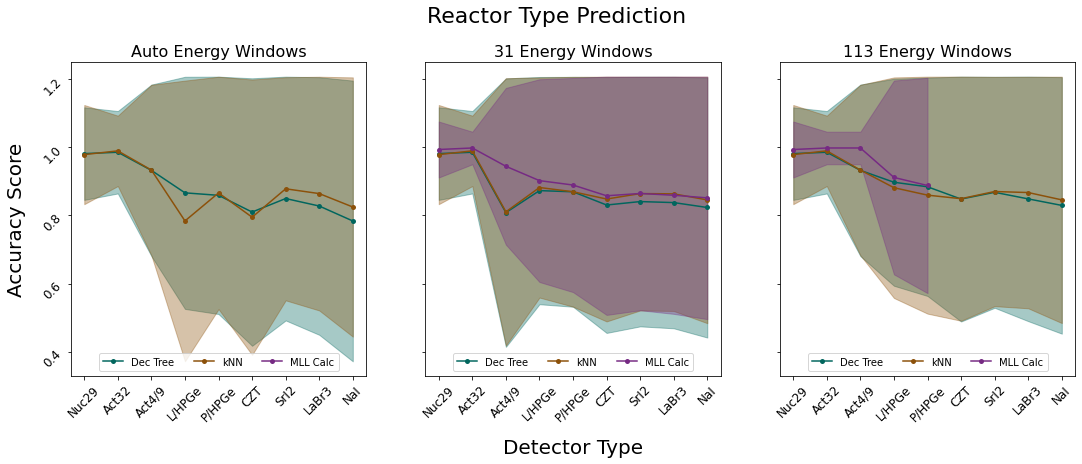

<Figure size 432x288 with 0 Axes>

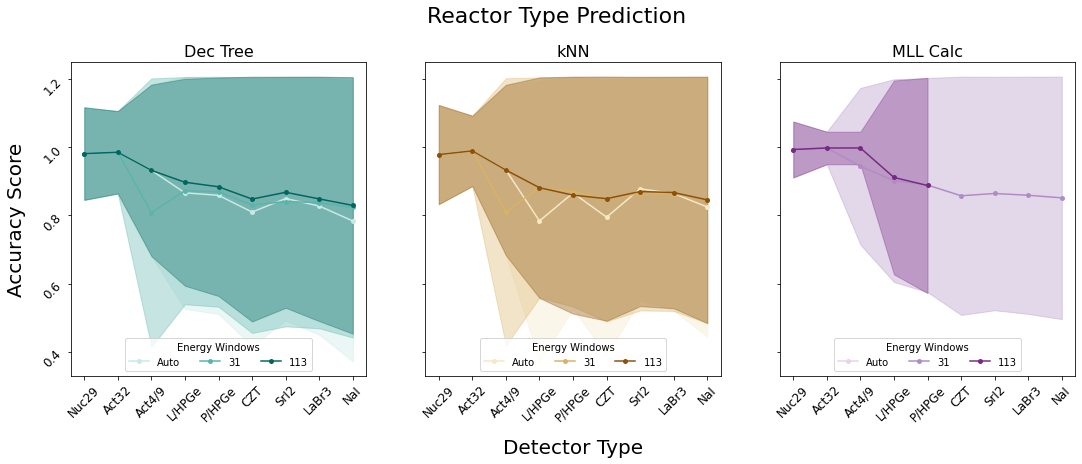

In [41]:
plot_by_enlist('reactor', 'Reactor Type Prediction')
plot_by_alg('reactor', 'Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

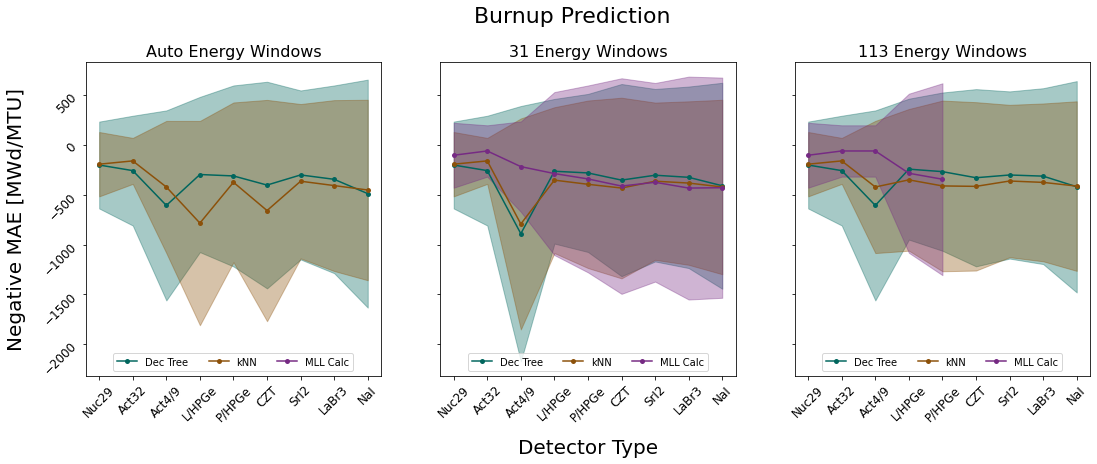

<Figure size 432x288 with 0 Axes>

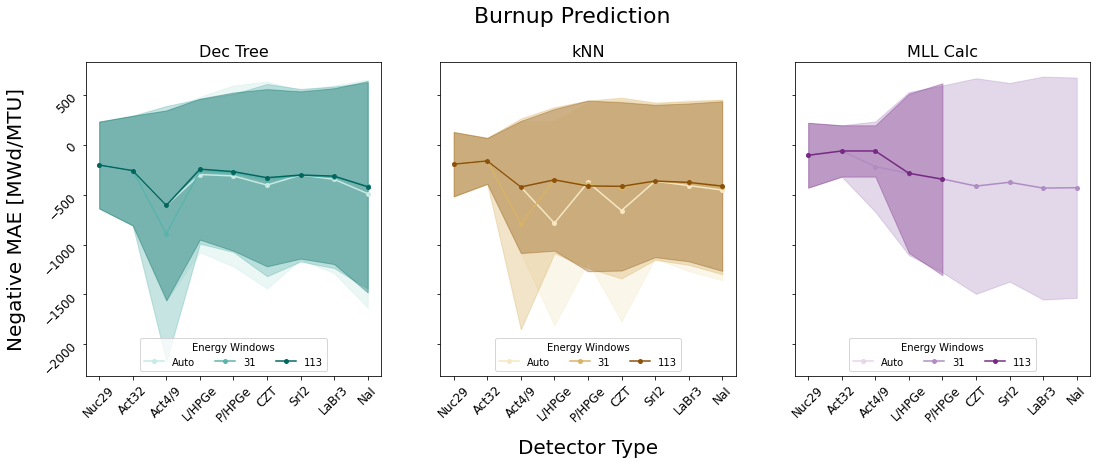

In [42]:
plot_by_enlist('burnup', 'Burnup Prediction')
plot_by_alg('burnup', 'Burnup Prediction')

<Figure size 432x288 with 0 Axes>

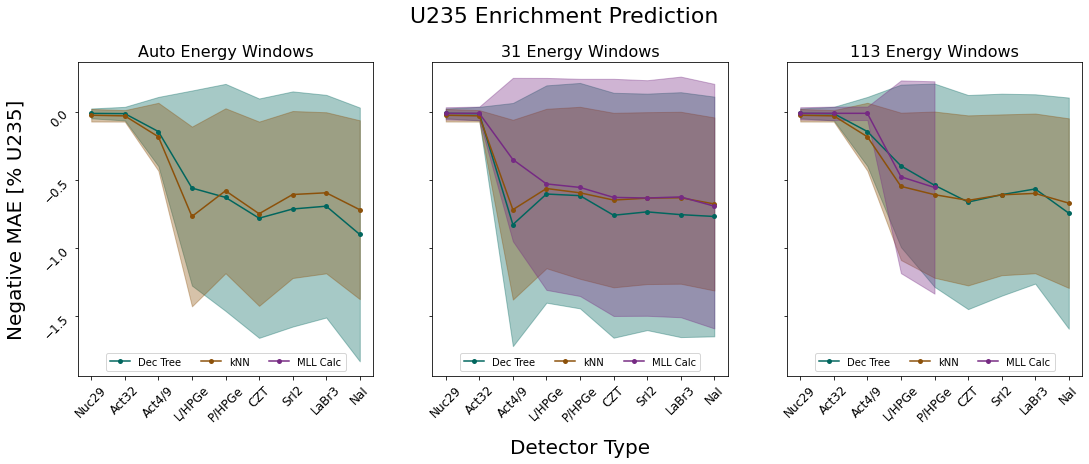

<Figure size 432x288 with 0 Axes>

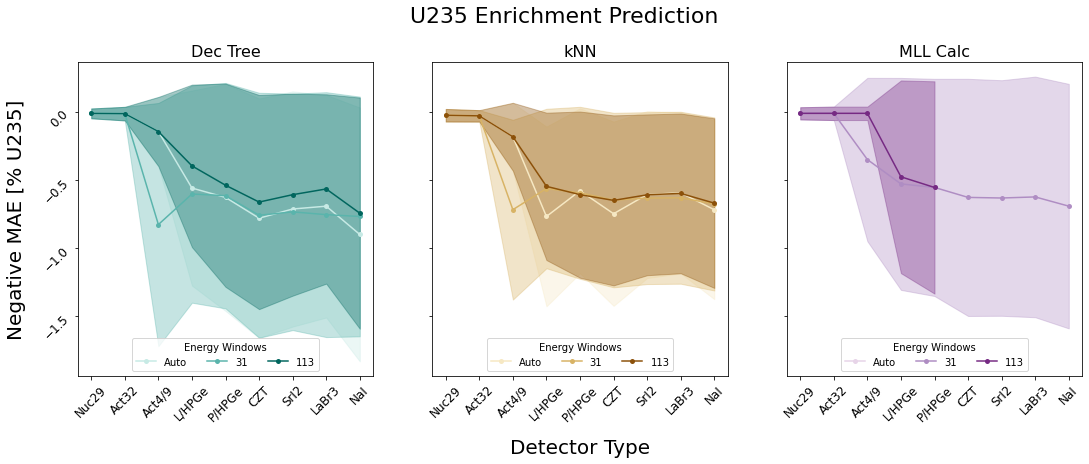

In [43]:
plot_by_enlist('enrichment', 'U235 Enrichment Prediction')
plot_by_alg('enrichment', 'U235 Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

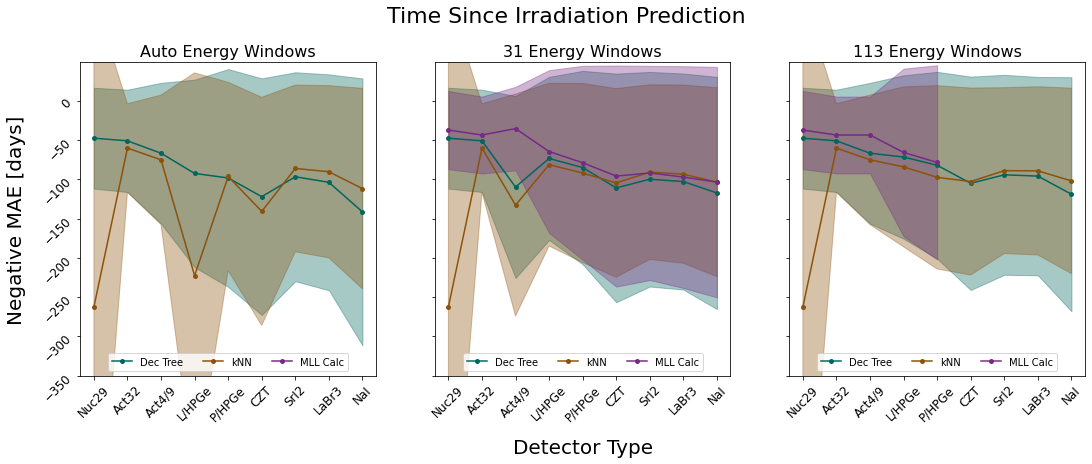

<Figure size 432x288 with 0 Axes>

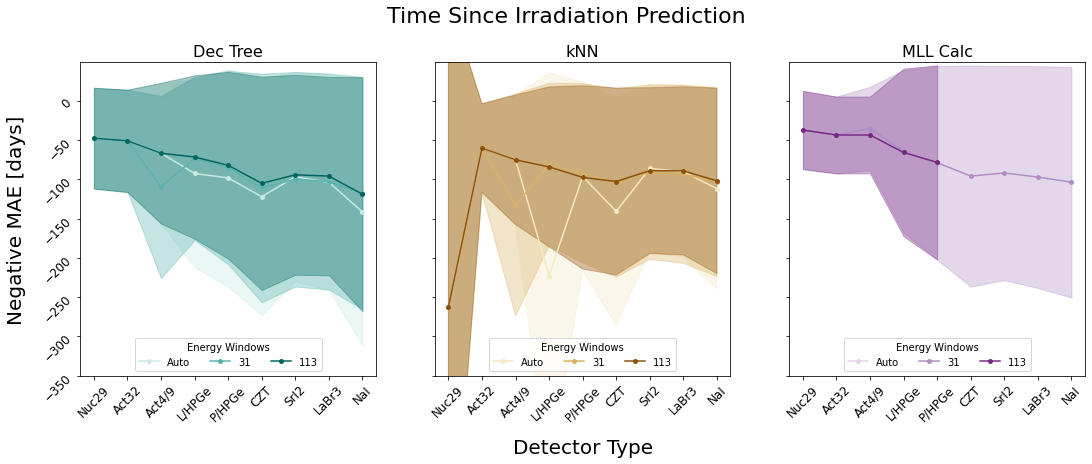

In [44]:
plot_by_enlist('cooling', 'Time Since Irradiation Prediction')
plot_by_alg('cooling', 'Time Since Irradiation Prediction')

In [45]:
# using more trainset for knn makes a huge difference. 
#this high error for knn for cooling time/nuc29 is easily resolved